# mESC analysis using Cyclum

We redesigned the core of Cyclum to a more friendly object oriented core. 

We still use the mESC dataset. For simplicity we have converted the dataset into TPM.

The original count data is available at ArrayExpress: [E-MTAB-2805](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-2805/).

## Import necessary packages

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np
import sklearn as skl

In [3]:
import cyclum.tuning
import cyclum.models
from cyclum import writer


Using TensorFlow backend.


## Read data
Here we have label, so we load both. However, the label is not used until evaluation. We have transformed the data into TPM values in R to facilitate the analysis. We further transform it to `s`tandardized and log2 `t`ransformed values, `sttpm`.

In [7]:
input_file_mask = 'data/mesc-tpm'

def preprocess(input_file_mask):
    """
    Read in data and perform log transform (log2(x+1)), centering (mean = 1) and scaling (sd = 1).
    """
    tpm = writer.read_df_from_binary(input_file_mask).T
    sttpm = pd.DataFrame(data=skl.preprocessing.scale(np.log2(tpm.values + 1)), index=tpm.index, columns=tpm.columns)
    
    label = pd.read_csv(input_file_mask + '-label.txt', sep="\t", index_col=0).T
    return sttpm, label

sttpm, label = preprocess(input_file_mask)

In [8]:
sttpm.shape

(288, 38293)

There is no convention whether cells should be columns or rows. Here we require cells to be rows.

## Set up the model and fit the model

Here we create an CyclumAutoTune object, and use it the whole dataset (`sttpm`) to tune it. The dimensionality is automatically determined, and we show a barplot to illustrate the selection. Note that using a subset of `sttpm` can accelerate it. ETA is available, but for each step. If `max_linear_dims` is 5, 6 such training step will be needed. To run it faster, `max_linear_dims` may be reduced to no less than 2.

In [9]:
model = cyclum.tuning.CyclumAutoTune(sttpm, max_linear_dims=5, 
                                     epochs=500, rate=2e-4, verbose=100,
                                     encoder_width=[30, 20])

Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch: 100/500, loss:  0.7183, time elapsed:  50.90s, time left:  203.61s
epoch: 200/500, loss:  0.7113, time elapsed:  82.43s, time left:  123.65s
epoch: 300/500, loss:  0.7084, time elapsed:  114.19s, time left:  76.13s
epoch: 400/500, loss:  0.7064, time elapsed:  145.56s, time left:  36.39s
epoch: 500/500, loss:  0.7061, time elapsed:  177.04s, time left:  0.00s
[0.7061273389392428]
[0.6834711496280971, 0.6739115521145238, 0.6668003108273485, 0.6607520129983886, 0.6550231866078591, 0.6501484225177175, 0.6453883289383507]
    1 linear dimensions...
epoch: 100/500, loss:  0.6778, time elapsed:  32.05s, time left:  128.20s
epoch: 200/500, loss:  0.6740, time elapsed:  63.86s, time left:  95.79s
epoch: 300/500, loss:  0.6727, time elapsed:  95.39s, tim

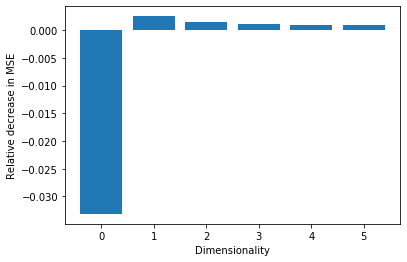

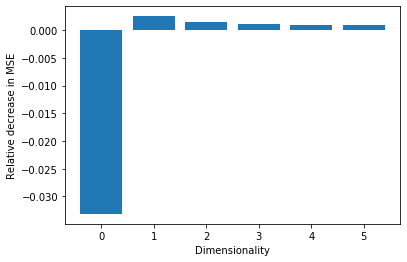

In [10]:
model.show_bar()

We show the structure of the best network.

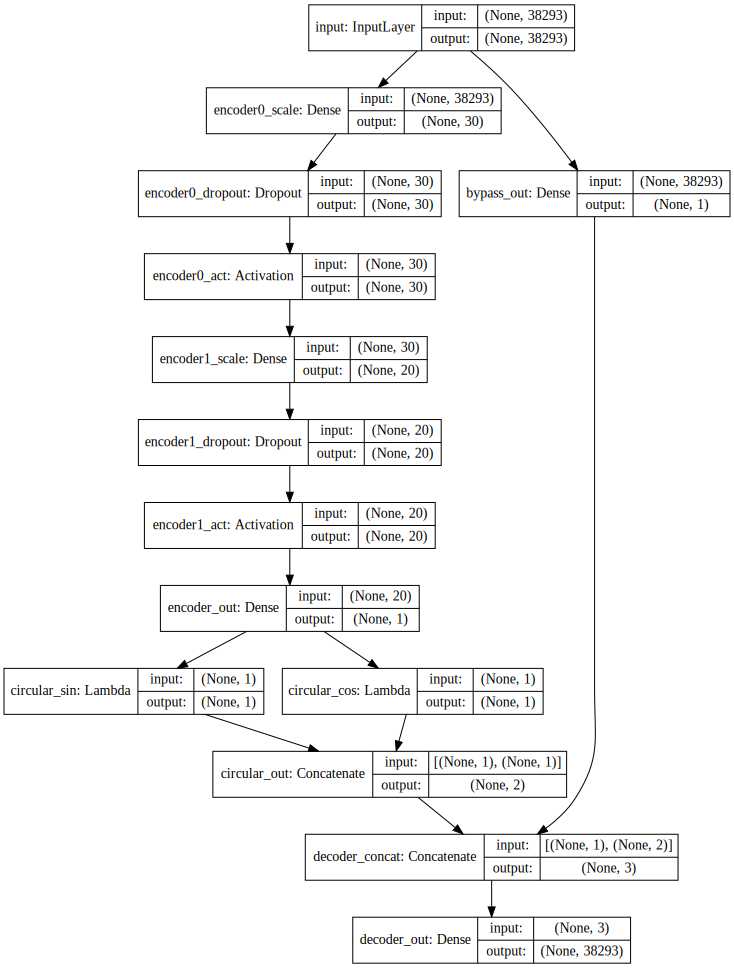

In [11]:
display(model.show_structure())

## Train the best model

No that we have decided the best dimensionality to be used, we can train the model on the whole dataset in a finer fashion (especially if a subset was used for tuning). The `train` can be called again to continue training if needed.

In [12]:
model.train(sttpm, epochs=800, verbose=100, rate=2e-4)

epoch: 100/800, loss:  0.6774, time elapsed:  31.89s, time left:  223.22s
epoch: 200/800, loss:  0.6739, time elapsed:  63.13s, time left:  189.38s
epoch: 300/800, loss:  0.6723, time elapsed:  94.32s, time left:  157.20s
epoch: 400/800, loss:  0.6719, time elapsed:  125.47s, time left:  125.47s
epoch: 500/800, loss:  0.6718, time elapsed:  156.66s, time left:  94.00s
epoch: 600/800, loss:  0.6714, time elapsed:  187.97s, time left:  62.66s
epoch: 700/800, loss:  0.6714, time elapsed:  219.23s, time left:  31.32s
epoch: 800/800, loss:  0.6713, time elapsed:  250.35s, time left:  0.00s


In [13]:
pseudotime = model.predict_pseudotime(sttpm)

## Illustrations
We illustrate the results on a circle, to show its circular nature. 
There is virtually no start and end of the circle.
Red, green and blue represents G0/G1, S and G2/M phase respectively.
The inner lines represents single cells. The cells spread across the
The areas outside

In [14]:
import cyclum.illustration

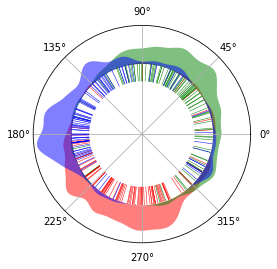

In [15]:
color_map = {'stage': {"g0/g1": "red", "s": "green", "g2/m": "blue"},
                 'subcluster': {"intact": "cyan", "perturbed": "violet"}}
cyclum.illustration.plot_round_distr_color(pseudotime, label['stage'], color_map['stage'])
pass


In [16]:
# Save the model and reload it later
# model.save("model.h5")
# cyclum.Autoencoder(filepath = "model.h5")

In [17]:
# Save the pseudotime to analyze in R
from cyclum.hdfrw import mat2hdf
mat2hdf(pseudotime, 'cyclum-pseudotime.h5')

In [18]:
# Save the dataset to anaylyze in R
# mat2hdf(sttpm, '/home/shaoheng/Documents/data/EMTAB2805/sttpm.h5')